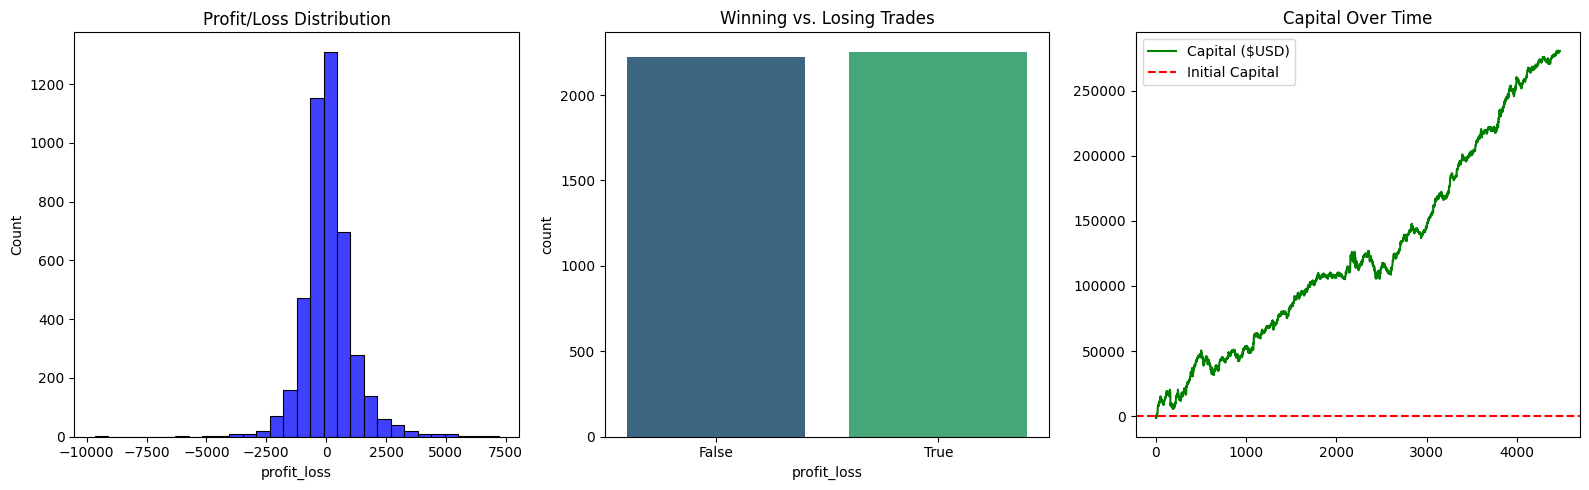

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
file_path = 'gc_trading_4h.csv'
data = pd.read_csv(file_path)

# Constants
initial_capital = 0  # Initial capital in USD
tick_value = 100  # Tick value in USD

# Initialize variables
capital = initial_capital
trades = []
position = None  # 'long' or 'short'

# Trading strategy loop
for i in range(1, len(data) - 1):
    previous_candle = data.iloc[i-1]
    current_candle = data.iloc[i]
    next_candle = data.iloc[i + 1]
    
    #is_bullish = current_candle['close'] > current_candle['open']
    #is_bearish = current_candle['close'] < current_candle['open']
    is_bullish = current_candle['close'] > (previous_candle['high'] + previous_candle['low']) / 2
    is_bearish = current_candle['close'] < (previous_candle['high'] + previous_candle['low']) / 2

    if is_bullish:
        position = 'long'
        entry_price = next_candle['open']
        exit_price = next_candle['close']
        profit_loss_1 = (exit_price - entry_price) * tick_value
        profit_loss_2 = 0
        
        if next_candle['low'] < (current_candle['high'] + current_candle['low']) / 2:
            position = 'short'
            short_entry_price = (current_candle['high'] + current_candle['low']) / 2
            exit_price = next_candle['close']
            profit_loss_1 = (short_entry_price - entry_price) * tick_value
            profit_loss_2 = (short_entry_price - exit_price) * tick_value
    
    elif is_bearish:
        position = 'short'
        entry_price = next_candle['open']
        exit_price = next_candle['close']
        profit_loss_1 = (entry_price - exit_price) * tick_value
        profit_loss_2 = 0
        
        if next_candle['high'] > (current_candle['high'] + current_candle['low']) / 2:
            position = 'long'
            long_entry_price = (current_candle['high'] + current_candle['low']) / 2
            exit_price = next_candle['close']
            profit_loss_1 = (entry_price - long_entry_price) * tick_value
            profit_loss_2 = (exit_price - long_entry_price) * tick_value
    
    capital += (1*profit_loss_1 + profit_loss_2) 
    trades.append({
        'time':current_candle['time'],
        'position': position,
        'entry_price': entry_price if position == 'short' else long_entry_price if 'long_entry_price' in locals() else None,
        'exit_price': exit_price,
        'profit_loss': 2*profit_loss_1 + profit_loss_2,
        'capital': capital
    })

# Convert trades to DataFrame and display
trades_df = pd.DataFrame(trades)


# EDA and Cumulative Performance Plot
plt.figure(figsize=(16, 5))
plt.subplot(1, 3, 1)
sns.histplot(trades_df['profit_loss'], bins=30, kde=False, color='blue')
plt.title('Profit/Loss Distribution')
plt.subplot(1, 3, 2)
sns.countplot(x=trades_df['profit_loss'] > 0, palette='viridis')
plt.title('Winning vs. Losing Trades')
plt.subplot(1, 3, 3)
plt.plot(trades_df['capital'], label='Capital ($USD)', color='green')
plt.title('Capital Over Time')
plt.axhline(y=initial_capital, color='r', linestyle='--', label='Initial Capital')
plt.legend()
plt.tight_layout()
plt.show()


In [6]:
data

,time,open,high,low,close,EMA,EMA.1,EMA.2,Volume,Volume MA
0,2020-10-01T02:00:00Z,1893.5,1901.3,1893.5,1898.4,1896.648170,1889.842270,1894.454792,9160,35397.55
1,2020-10-01T06:00:00Z,1898.6,1905.6,1898.2,1902.9,1896.893340,1891.085863,1896.566094,27594,36135.25
2,2020-10-01T10:00:00Z,1902.8,1915.3,1900.3,1908.3,1897.340660,1892.725305,1899.499571,63025,38581.40
3,2020-10-01T14:00:00Z,1908.4,1917.9,1901.6,1912.0,1897.915536,1894.560990,1902.624678,102854,41767.00
4,2020-10-01T18:00:00Z,1912.1,1916.5,1909.7,1911.7,1898.456103,1896.193277,1904.893508,43203,39851.30
...,...,...,...,...,...,...,...,...,...,...
4475,2023-08-24T18:00:00Z,1945.2,1946.0,1944.0,1944.7,1936.323966,1937.893563,1944.363290,6577,22770.10
4476,2023-08-24T22:00:00Z,1944.9,1945.7,1942.6,1945.0,1936.664203,1938.570366,1944.522468,8597,21341.75
4477,2023-08-25T02:00:00Z,1944.9,1945.1,1940.7,1942.3,1936.885214,1938.925569,1943.966851,14881,21683.15
4478,2023-08-25T06:00:00Z,1942.3,1945.6,1940.4,1943.7,1937.152461,1939.380277,1943.900138,13084,21984.75


/tmp/ipykernel_474/4064216818.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trades_df_filt['capital'] = trades_df_filt['profit_loss'].cumsum() + initial_capital


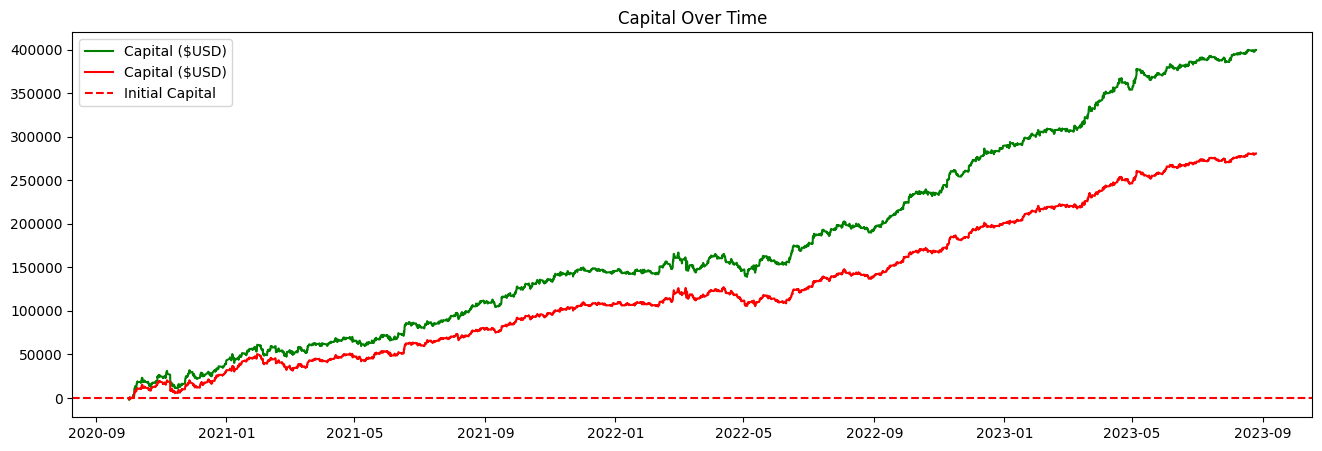

In [7]:
#plot capital excluding hours between 12:00 and 14:00
trades_df = trades_df.reset_index()
trades_df['time'] = pd.to_datetime(trades_df['time'])
trades_df = trades_df.set_index('time')
trades_df_filt = trades_df.between_time('01:00', '22:00')
trades_df_filt['capital'] = trades_df_filt['profit_loss'].cumsum() + initial_capital

#plot capital
plt.figure(figsize=(16, 5))
plt.plot(trades_df_filt['capital'], label='Capital ($USD)', color='green')
plt.plot(trades_df['capital'], label='Capital ($USD)', color='red')
plt.title('Capital Over Time')
plt.axhline(y=initial_capital, color='r', linestyle='--', label='Initial Capital')
plt.legend()



In [8]:
trades_df_filt[:13]

,index,position,entry_price,exit_price,profit_loss,capital
time,,,,,,
2020-10-01 06:00:00+00:00,0,short,1902.80,1908.3,-820.0,-820.0
2020-10-01 10:00:00+00:00,1,short,1908.40,1912.0,-540.0,-1360.0
2020-10-01 14:00:00+00:00,2,short,1912.10,1911.7,-665.0,-2025.0
2020-10-01 18:00:00+00:00,3,short,1911.00,1903.2,1410.0,-615.0
2020-10-01 22:00:00+00:00,4,long,1908.15,1910.9,-715.0,-1330.0
2020-10-02 02:00:00+00:00,5,long,1908.15,1913.9,560.0,-770.0
2020-10-02 06:00:00+00:00,6,short,1913.70,1908.3,1560.0,790.0
2020-10-02 10:00:00+00:00,7,long,1910.25,1905.8,-855.0,-65.0
2020-10-02 14:00:00+00:00,8,long,1909.50,1904.1,-1300.0,-1365.0
